In [2]:
from utils import *

In [34]:
def saveNCrop(img_path, xys, grid_size=64, ratio=10, offset=5):
    # offset between img and loc
    # img = cv2.imread(img_path)
    loc = img_path[:-3] + "txt"
    smlm = pd.read_table(loc, header=0)
    # xyz = smlm[["Xc","Yc","Zc"]]
    for xy in xys:
        cropped = smlm.loc[
            (xy[1] / (ratio + offset) <= smlm["Xc"])
            & (smlm["Xc"] <= ((xy[1] + grid_size + offset)) / ratio)
            & (xy[0] / (ratio + offset) <= smlm["Yc"])
            & (smlm["Yc"] <= (xy[0] + grid_size + offset) / ratio)
        ]
        cropped.loc[:, "Xc"] = cropped["Xc"] * ratio - xy[1] - offset
        cropped.loc[:, "Yc"] = cropped["Yc"] * ratio - xy[0] - offset
        sub_path = (
            "/".join(img_path.split("/")[:-1])
            + "/sub_"
            + img_path.split("/")[-1][:-4]
            + "_x"
            + str(xy[1])
            + "_y"
            + str(xy[0])
            + "_grid"
            + str(grid_size)
        )
        #cropped.to_csv(sub_path + ".txt", index=False)
        xc = np.array(cropped["Xc"].tolist()).astype(np.int32)
        yc = np.array(cropped["Yc"].tolist()).astype(np.int32)
        img = grid2D(
            np.zeros([grid_size, grid_size], dtype=np.int32),
            xc,
            yc,
            grid_size,
            grid_size,
            len(xc),
        )
        np.save(sub_path,img)
        g = cv2.getGaussianKernel(3, sigma=1)
        kernel = g * g.T
        nimg = scipy.signal.fftconvolve(img, kernel, mode="same")
        plt.imshow(nimg.T)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.savefig(
            sub_path + ".png",
            facecolor=None,
            edgecolor=None,
            bbox_inches="tight",
            pad_inches=0.0,
        )
        plt.close('all')

In [3]:
test_boran=glob.glob("../data/rendered/soma/Boran/*.txt")
for i in test_boran:#[0:1]:
    #smlm = pd.read_table(i, header=0)
    txt2npy(i)

NameError: name 'txt2npy' is not defined

In [14]:
# img_path="../data/rendered/soma/0227_11.png"
# x0, y0, sx, sy=1050, 900, 700, 800

# img_path="../data/rendered/soma/0227_20.png"
# x0, y0, sx, sy=900, 700, 950, 950

# img_path="../data/rendered/soma/0227_21.png"
# x0, y0, sx, sy=800, 500, 1000, 1300

# img_path="../data/rendered/soma/1226_2.png"
# x0, y0, sx, sy=500, 500, 1000, 1300

# for pi in ["A1","A2","A3","A5","A6","A7","NA1","NA2","NA5"]:
#     img_path="../data/rendered/Tcell/"+pi+".png"


    x0, y0, sx, sy=0, 0, 2560, 2560

    pad=100
    grid_size = 64

    img = cv2.imread(img_path)
    plt.figure(figsize=[20,20])
    plt.imshow(img[x0:x0+sx,y0:y0+sy])
    xys=[]
    for i in range(pad,sx-pad,64):
        for j in range(pad,sy-pad,64):
            x = i
            y = j
            if np.sum(img[x0+x:x0+64+x,y0+y:y0+y+64]) > 100000:
                xys.append([x0+x, y0+y])
                plt.gca().add_patch(Rectangle((y,x),64,64,linewidth=3,edgecolor="red",facecolor='none'))
            

    saveNCrop(img_path, xys)

In [59]:
def txt2npy(loc_file, grid_size=64,scale=1):
    #smlm = pd.read_csv(loc_file, header=0)
    smlm = pd.read_table(loc_file, header=0)
    # xc = (np.array(smlm["Xc"].tolist())*scale).astype(np.int32)
    # yc = (np.array(smlm["Yc"].tolist())*scale).astype(np.int32)
    xc = smlm["Xc"].tolist()
    yc = smlm["Yc"].tolist()
    xc = np.array([int((x - min(xc))*scale) for x in xc]).astype(np.int32) #- int(scale/2)
    yc = np.array([int((x - min(yc))*scale) for x in yc]).astype(np.int32) #- int(scale/2)
    if grid_size!=0:
        img = grid2D(
            np.zeros([grid_size, grid_size], dtype=np.int32),
            xc,
            yc,
            grid_size,
            grid_size,
            len(xc),
        )
    else:
        len_x = max(xc)-min(xc)
        len_y = max(yc)-min(yc)
        grid_size = max(len_x, len_y)
        img = grid2D(
            np.zeros([grid_size, grid_size], dtype=np.int32),
            xc,
            yc,
            grid_size,
            grid_size,
            len(xc),
        )
    npy_path =  loc_file[:-4]+".npy"
    np.save(npy_path,img)


In [58]:
locs

['../data/rendered/soma/Boran\\storm_647_add_0006_list_1.txt',
 '../data/rendered/soma/Boran\\storm_647_add_0006_list_2.txt',
 '../data/rendered/soma/Boran\\storm_add_647_0004_list_1.txt',
 '../data/rendered/soma/Boran\\storm_add_647_0006_list_2.txt',
 '../data/rendered/soma/Boran\\storm_add_647_0008_list_1.txt']

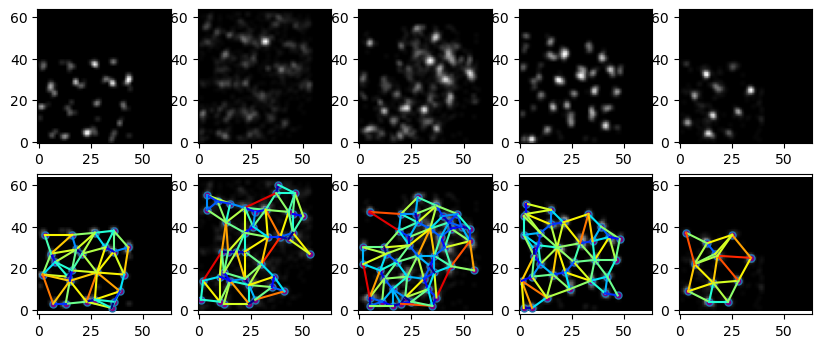

In [60]:
def readVXSfromMat(mat, grid_size=64, plot=0, **cluster_args):
    img = renderImg(mat, k_size=5, sigma=1)
    vxs, r = blob(img, **cluster_args)
    if plot == 1:
        ax = plt.subplots(111)
        plt.imshow(img)
        for i in range(len(vxs)):
            c = plt.Circle(
                (vxs[i, 0], vxs[i, 1]), r[i], color="red", linewidth=2, fill=False
            )
            ax.add_patch(c)
        ax.set_axis_off()
    return vxs, r

locs = glob.glob("../data/rendered/soma/Boran/*.txt")
g = cv2.getGaussianKernel(3, sigma=1)
kernel = g*g.T
plt.subplots(2,5,figsize=[10,4])
p_size=16.7
t_r=0.15
thre=[50,280]
for i in range(len(locs)):
    loc = locs[i]
    plt.subplot(2,5,i+1)
    txt2npy(loc, grid_size=64,scale=10)
    img = np.load(loc[:-3]+"npy")
    nimg = scipy.signal.fftconvolve(img, kernel, mode='same')
    plt.imshow(nimg)
    plt.gca().invert_yaxis()
    plt.subplot(2,5,i+6)
    plt.imshow(nimg)
    vxs = readVXSfromMat(img, plot=0,min_sigma=0.5,max_sigma=1,num_sigma=20, threshold_rel=t_r)[0]
    links = generateLinks(vxs * p_size, thre=thre, plot=0)
    visualize(vxs, links,thre=thre, p_size=16)


In [34]:
np.sum(nimg)

0.0

In [32]:
test_rand=glob.glob("../data/rendered/soma/Rand/*.txt")
test_1d=glob.glob("../data/rendered/soma/1D/*.txt")
test_2d=glob.glob("../data/rendered/soma/2D/*.txt")
for i in test_2d:
    txt2npy(i)

In [ ]:
smlm = pd.read_csv(sub_path+'.txt', header=0)
xc=np.array(smlm["Xc"].tolist()).astype(np.int32)
yc=np.array(smlm["Yc"].tolist()).astype(np.int32)
img = grid2D(np.zeros([grid_size,grid_size], dtype=np.int32),xc,yc,grid_size,grid_size,len(xc))
g = cv2.getGaussianKernel(3, sigma=1)
kernel = g*g.T
nimg = scipy.signal.fftconvolve(img, kernel, mode='same')
plt.imshow(nimg)

In [ ]:
img_path="../data/rendered/soma/0227_9.png"
img = cv2.imread(img_path)
plt.figure(figsize=[20,20])
plt.imshow(img[800+64*3:1600,800+64*3:1600])
for i in range(50,400,64):
    for j in range(60,500,64):
        x = i
        y = j
        xy = [800+x+64*3, 800+64*3+y]
        plt.gca().add_patch(Rectangle((y,x),64,64,linewidth=3,edgecolor="red",facecolor='none'))
        #plt.figure()
        grid_size = 64
        #a,b=saveCrop(img_path, xy)
        #plt.imshow(img[xy[0]:xy[0]+grid_size,xy[1]:xy[1]+grid_size])

In [ ]:
img_path="../data/rendered/soma/1226_5.png"
img = cv2.imread(img_path)
plt.figure(figsize=[20,20])
plt.imshow(img[800:1400,1100:1700])
for i in range(30,500,64):
    for j in range(0,560,64):
        x = i
        y = j
        xy = [800+x, 1100+y]
        #plt.gca().add_patch(Rectangle((y,x),64,64,linewidth=3,edgecolor="red",facecolor='none'))
        #plt.figure()
        grid_size = 64
        a,b=saveCrop(img_path, xy)
        #plt.imshow(img[xy[0]:xy[0]+grid_size,xy[1]:xy[1]+grid_size])

In [ ]:
for i in range(2,7):
    print(i)
    g = cv2.getGaussianKernel(3, sigma=i/4)
    kernel = g*g.T

    img = scipy.signal.fftconvolve(img, kernel, mode='same')
    plt.figure()
    #plt.imshow(img)
    vxs = lmax_loc(None,None,nimg,adapt=55,local=7,sm=3,plot=1)[1]

In [ ]:
sub_path = "sub_"+img_path.split("/")[-1][:-3]+"_x"+str(xy[1])+"_y"+str(xy[0])+"_grid"+str(grid_size)
cropped.to_csv(sub_path, index=False)
